In [ ]:
# !pip install fastai

In [ ]:
# auto-updating
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Setting Random Seed and Using CUDA for GPU Processing

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import glob
from sklearn.preprocessing import LabelEncoder
import os
import torch
import fastai
import time
from fastai.vision import *
np.random.seed(0) 
from torchvision.models import resnet50
from torchvision.models import mobilenet_v2
from torchvision.models import vgg16
from fastai.callbacks import *
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from fastai import *
# from fastai.dataset import ModelData,ArraysIndexDataset
# from fastai.dataloader import DataLoader
# from fastai.learner import Learner

import torch
import torch.nn as nn

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

def random_seed(seed_value, use_cuda):  
    np.random.seed(seed_value) 
    torch.manual_seed(seed_value) 
    random.seed(seed_value) 
    torch.backends.cudnn.deterministic = True

    if use_cuda: torch.cuda.manual_seed_all(seed_value) 

# Set seed
#random_seed(0,False)
random_seed(0,True)

In [ ]:
#from fastai.callbacks import CSVLogger

In [ ]:
SEED = 1
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA_LAUNCH_BLOCKING=1

CUDA Available? True


In [ ]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set batch size of images 
bs = 4
 #32  #64

image_path = Path(r"/content/drive/My Drive/IMAGES/train")
# model_save_path = Path("C:/Users/DAR9KOR/Desktop/data/sample_datasets/defect_detection/1_data/Schaeffler/VQI/")

image_path.ls()

[PosixPath('/content/drive/My Drive/IMAGES/train/history.csv'),
 PosixPath('/content/drive/My Drive/IMAGES/train/Cr'),
 PosixPath('/content/drive/My Drive/IMAGES/train/Sc'),
 PosixPath('/content/drive/My Drive/IMAGES/train/PS'),
 PosixPath('/content/drive/My Drive/IMAGES/train/In'),
 PosixPath('/content/drive/My Drive/IMAGES/train/RS'),
 PosixPath('/content/drive/My Drive/IMAGES/train/Pa'),
 PosixPath('/content/drive/My Drive/IMAGES/train/models'),
 PosixPath('/content/drive/My Drive/IMAGES/train/export.pkl')]

In [ ]:
## load data
# fastai is automatically supposed to handle image format conversions- greyscale(L), RGB

# https://forums.fast.ai/t/how-to-load-images-as-grayscale/36895/6
# google: can fastai convert greyscale images to RGB

data = ImageDataBunch.from_folder(image_path, 
                                  valid_pct=0.3,
                                  ds_tfms=get_transforms(), 
                                  size=512, 
                                  bs=bs, 
                                  num_workers=1,
                                  seed=9).normalize(imagenet_stats)

In [ ]:
data

ImageDataBunch;

Train: LabelList (1009 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
Cr,Cr,Cr,Cr,Cr
Path: /content/drive/My Drive/IMAGES/train;

Valid: LabelList (432 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
Pa,Sc,PS,Pa,Sc
Path: /content/drive/My Drive/IMAGES/train;

Test: None

In [ ]:
data.classes
data.c
len(data.train_ds)
len(data.valid_ds)

['Cr', 'In', 'PS', 'Pa', 'RS', 'Sc']

6

1009

432

In [ ]:
# count no. of examples in train & validation sets 
# train set
vc = pd.value_counts(data.train_ds.y.items, sort =False)
vc.index = data.classes
vc
# ratio

Cr    167
In    179
PS    159
Pa    156
RS    181
Sc    167
dtype: int64

In [ ]:
# val set
vc = pd.value_counts(data.valid_ds.y.items, sort =False)
# vc.index = data.classes
vc
# ratio

0    70
1    61
2    77
3    80
4    70
5    74
dtype: int64

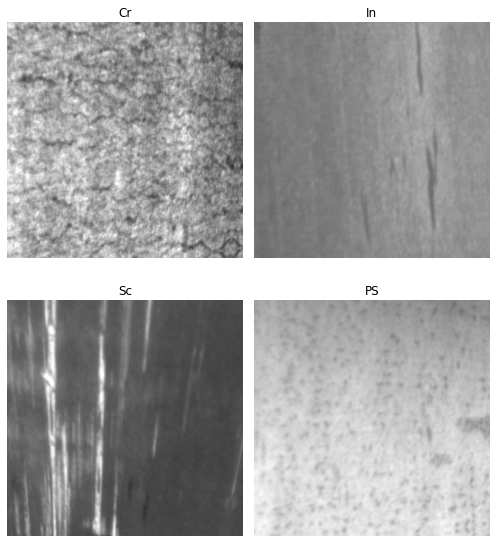

In [ ]:
data.show_batch(rows=3, figsize=(7,8))
#data.show_batch(rows=3, figsize=(10,10), ds_type=DatasetType.Valid)
#data.show_batch(rows=3, figsize=(10,10), ds_type=DatasetType.Train)

In [ ]:
precision = Precision()
recall = Recall()
metrics = [accuracy,precision,recall]

### MobileNet_V2

In [ ]:
#callback_fn=partial(CSVLogger, filename=f'sample_history_stage1')

In [ ]:
# Initialize cnn_learner object with the right model and its pretrained weights
learn = cnn_learner(data, mobilenet_v2, pretrained=True, metrics=metrics, cut=-1,callback_fns=[partial(CSVLogger)])


learn.loss_func = torch.nn.functional.cross_entropy
# learn.loss_func = nn.CrossEntropyLoss(weight=class_weights)
#cb=CSVLogger(learn)

#EarlyStoppingCallback(learn, monitor='accuracy', min_delta=0.01, patience=3),
callbacks = [EarlyStoppingCallback(learn, monitor='accuracy', min_delta=0.01, patience=3),
             SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='Mobile_Net')]
learn.callbacks = callbacks

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision,recall,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.51E-01
Min loss divided by 10: 1.91E-03


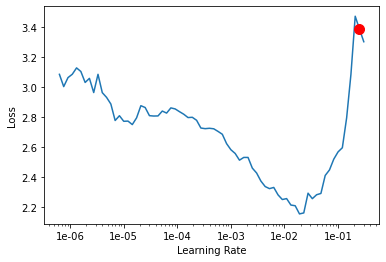

In [ ]:
learn.recorder.plot(suggestion=True)

In [ ]:
learn.path

WindowsPath('C:/Users/Desktop/VQI/Classification Codes/data/IMAGES/train')

In [ ]:
# Fit one cycle method for a number of epochs
epochs = 15
learn.fit_one_cycle(epochs)
#torch.save(learn.model.state_dict(), f'{fname}_{fold}.pth')

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,1.045544,0.116125,0.958333,0.964270,0.958499,03:09
1,0.743177,0.239765,0.928241,0.941398,0.927703,02:59
2,0.912205,0.114950,0.958333,0.962613,0.959463,03:00
3,0.680003,0.181101,0.944444,0.959251,0.940789,03:01
4,0.598955,0.065642,0.974537,0.974399,0.975991,03:02
5,0.479548,0.088671,0.974537,0.974806,0.975694,03:07
6,0.583850,0.044006,0.990741,0.991285,0.991285,03:01
7,0.487128,0.050300,0.981481,0.981401,0.982159,03:07
8,0.294642,0.091997,0.974537,0.974371,0.976105,02:55
9,0.222501,0.041155,0.986111,0.986368,0.986459,02:59


c:\users\appdata\local\programs\python\python36\lib\site-packages\fastai\metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


Better model found at epoch 0 with valid_loss value: 0.11612499505281448.
Better model found at epoch 2 with valid_loss value: 0.11494989693164825.
Better model found at epoch 4 with valid_loss value: 0.06564205884933472.
Better model found at epoch 6 with valid_loss value: 0.04400617629289627.
Better model found at epoch 9 with valid_loss value: 0.041155196726322174.
Epoch 10: early stopping


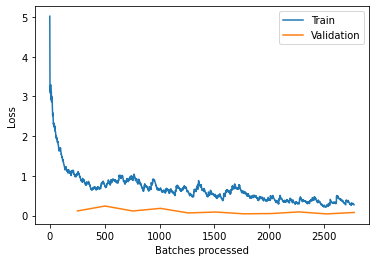

In [ ]:
learn.recorder.plot_losses()

In [ ]:
# Get the predictions for validation set and store as numpy array
preds = learn.get_preds()[0].argmax(dim=-1).numpy()
test_actual = learn.get_preds()[1].numpy()

# Get the predictions for training set and store as numpy array
train_pred = learn.get_preds(ds_type=DatasetType.Train)[0].argmax(dim=-1).numpy()
train_actual = learn.get_preds(ds_type=DatasetType.Train)[1].numpy()

# Calculate accuracy_score and append to Dataframe
val_acc = accuracy_score(test_actual, preds)
train_acc = accuracy_score(train_actual, train_pred)

In [ ]:
val_acc, train_acc

(0.9861111111111112, 0.1746031746031746)

In [ ]:
train_pred.shape, train_actual.shape

((1008,), (1008,))

In [ ]:
preds.shape, test_actual.shape

((432,), (432,))

In [ ]:
confusion_matrix(test_actual, preds)

array([[69,  0,  0,  0,  0,  0],
       [ 0, 76,  1,  0,  0,  0],
       [ 0,  0, 63,  0,  0,  1],
       [ 0,  0,  0, 78,  0,  0],
       [ 0,  0,  0,  0, 68,  0],
       [ 0,  3,  0,  0,  1, 72]], dtype=int64)

In [ ]:
confusion_matrix(train_actual, train_pred)

array([[27, 25, 27, 32, 26, 28],
       [30, 31, 27, 28, 31, 24],
       [22, 28, 31, 30, 22, 29],
       [27, 28, 27, 21, 31, 28],
       [29, 32, 29, 26, 35, 28],
       [28, 26, 24, 29, 31, 31]], dtype=int64)

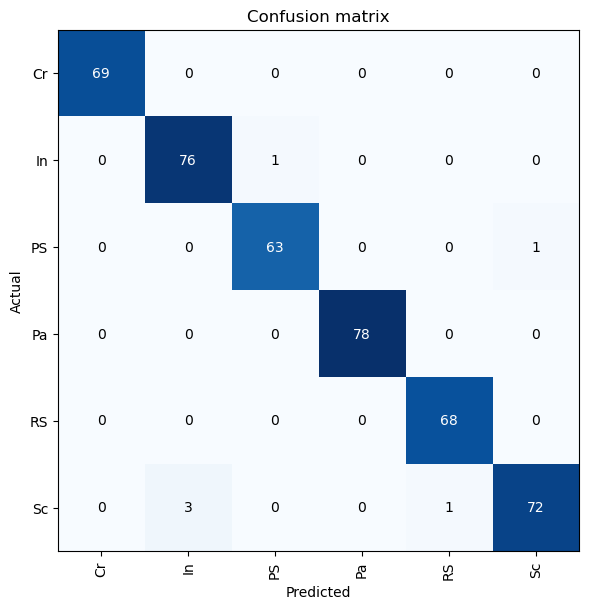

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6), dpi=100)

In [ ]:
learn.export(r"C:\Users\Desktop\VQI\Classification Codes\data\IMAGES\train\mobilenetv2_Callbacks.pkl")
#learn.save(os.path.join(model_save_path,'/resnet34_nocrk6000_epc2_stage-2'))
learn.save(r'C:\Users\Desktop\VQI\Classification Codes\data\IMAGES\train\mobilenetv2_Callbacks')

### Testing on New Images

In [ ]:
learn.load(r'C:\Users\Desktop\VQI\Classification Codes\data\IMAGES\train\mobilenetv2_Callbacks')

In [ ]:
# predicting on a separate set, with labeled data
# use this method if there are several folders withing test folder
test_directory = r'C:\Users\Desktop\VQI\Classification Codes\data\IMAGES\test'
images = []

for r, d, f in os.walk(test_directory):
    for file in f:
        #if file.endswith(".docx"):
        images.append(os.path.join(r, file))


In [ ]:
images

[]

In [ ]:
from fastai.vision import image
pred = []

for i in images:
    #img = image.open_image(test_directory+i)   # NameError: name 'image' is not defined  if image is not imported
    img = image.open_image(i)
    pred_class,pred_idx,outputs = learn.predict(img)
    pred.append(str(pred_class))



In [ ]:
actual = []

for item in images:   # can be used if images are in sub-folders within test
#for item in os.listdir(test_directory):  # only when images are directly in "test"
    if 'Cr' in item:
        actual.append('Cr')
    if 'In' in item:
        actual.append('In')
    if 'Pa' in item:
        actual.append('Pa')
    if 'PS' in item:
        actual.append('PS')  
    if 'RS' in item:
        actual.append('RS')
    if 'Sc' in item:
        actual.append('Sc')        

In [ ]:
pred

[]

In [ ]:
actual

[]

In [ ]:
Test_Results={}

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

class_names = ['Cr', 'In', 'Pa', 'PS', 'RS', 'Sc']
report=classification_report(actual, pred, target_names=class_names)
Classifiaction_Report=classification_report(actual, pred, target_names=class_names)
Test_Results["Classification Report"]=Classifiaction_Report

In [ ]:
print(Classifiaction_Report)

In [ ]:
#Ref
def report_to_df(report):
    report = [x.split(' ') for x in report.split('\n')]
    header = ['Class Name']+[x for x in report[0] if x!='']
    values = []
    for row in report[1:-5]:
        row = [value for value in row if value!='']
        if row!=[]:
            values.append(row)
    df = pd.DataFrame(data = values, columns = header)
    return df

In [ ]:
Accuracy_Score=accuracy_score(actual, pred)
Test_Results["Accuracy_Score"]=Accuracy_Score

In [ ]:
import pandas as pd
Confusion_Matrix_List=[]
Confusion_matrix=pd.DataFrame(confusion_matrix(actual,pred,labels=class_names))
for index, row in Confusion_matrix.iterrows():
    Confusion_Matrix_List.append(list(row))
Test_Results["Confusion_Matrix"]=Confusion_Matrix_List

In [ ]:
Test_Results

In [ ]:
import json
with open('data.json', 'w') as f:
    json.dump(Test_Results, f)

In [ ]:
#o read json
import json
with open('data.json',"r") as f:
    json.load(f)

In [ ]:
cnf_matrix = confusion_matrix(actual, pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')


### VGG16

In [ ]:
learn1 = cnn_learner(data, vgg16, pretrained=True, metrics=metrics)
# Below is needed since you get negative loss otherwise Ref: https://forums.fast.ai/t/negative-loss-with-letters-mnist/30889/15
# learn.loss_func = torch.nn.functional.cross_entropy
learn1.loss_func = nn.CrossEntropyLoss(weight=class_weights)

callbacks = [EarlyStoppingCallback(learn1, monitor='accuracy', min_delta=0.01, patience=3), SaveModelCallback(learn1, every='improvement', monitor='accuracy')]
learn1.callbacks = callbacks

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


By default, only the fully connected layers at the top are unfrozen (can be trained) (only in Fastai not Pytorch) ((i.e. requires_grad=False for all layers except FCN)

In [ ]:
learn1.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,2.319911,1.910482,0.103448,nan,0.321429,00:10
1,1.958246,1.237220,0.517241,nan,0.287594,00:03
2,1.551973,1.266010,0.551724,0.460714,0.604323,00:03
3,1.320657,1.307225,0.586207,0.658333,0.617481,00:03
4,1.090372,1.330631,0.586207,0.628125,0.706767,00:03
5,0.905562,1.332464,0.586207,nan,0.380639,00:03
6,0.773023,1.378348,0.586207,nan,0.380639,00:03


Better model found at epoch 0 with accuracy value: 0.1034482792019844.
Better model found at epoch 1 with accuracy value: 0.517241358757019.
Better model found at epoch 2 with accuracy value: 0.5517241358757019.
Better model found at epoch 3 with accuracy value: 0.5862069129943848.
Epoch 7: early stopping


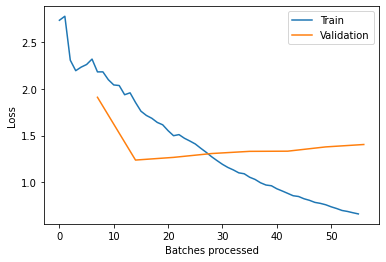

In [ ]:
learn1.recorder.plot_losses()

In [ ]:
# Get the predictions for validation set and store as numpy array
preds = learn1.get_preds()[0].argmax(dim=-1).numpy()
test_actual = learn1.get_preds()[1].numpy()

# Get the predictions for training set and store as numpy array
train_pred = learn1.get_preds(ds_type=DatasetType.Train)[0].argmax(dim=-1).numpy()
train_actual = learn1.get_preds(ds_type=DatasetType.Train)[1].numpy()

# Calculate accuracy_score and append to Dataframe
val_acc = accuracy_score(test_actual, preds)
train_acc = accuracy_score(train_actual, train_pred)

In [ ]:
val_acc, train_acc

(0.5862068965517241, 0.45535714285714285)

In [ ]:
confusion_matrix(test_actual, preds)

array([[13,  0,  0,  6],
       [ 0,  1,  0,  0],
       [ 2,  0,  2,  3],
       [ 0,  0,  1,  1]])

In [ ]:
confusion_matrix(train_actual, train_pred)

array([[43,  5, 15, 11],
       [ 3,  0,  1,  1],
       [13,  1,  7,  3],
       [ 4,  1,  3,  1]])

### ResNet50

In [ ]:
learn2 = cnn_learner(data, resnet50, pretrained=True, metrics=metrics)
learn2.loss_func = torch.nn.functional.cross_entropy

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


By default, only the fully connected layers at the top are unfrozen (can be trained) (only in Fastai not Pytorch) ((i.e. requires_grad=False for all layers except FCN)

In [ ]:
learn2.fit_one_cycle(20)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,2.541088,1.394131,0.586207,nan,0.223684,00:08
1,2.066768,1.742163,0.482759,nan,0.421053,00:04
2,1.687377,1.428046,0.413793,nan,0.439850,00:04
3,1.333429,1.770467,0.310345,nan,0.163534,00:04
4,1.149831,1.601366,0.448276,0.320833,0.453008,00:04
5,0.954081,1.203817,0.689655,0.434722,0.567669,00:04
6,0.795043,1.015514,0.724138,0.750000,0.692669,00:04
7,0.664323,0.898260,0.620690,nan,0.281955,00:04
8,0.586723,0.944132,0.689655,nan,0.330827,00:04
9,0.507827,0.816107,0.689655,0.462500,0.420113,00:04


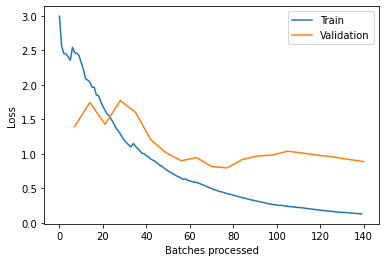

In [ ]:
learn2.recorder.plot_losses()

In [ ]:
# # Let's find the best learning rate
# learn2.unfreeze()
# learn2.lr_find()
# # Plot the learning rate
# learn2.recorder.plot()

In [ ]:
# learn.unfreeze()
# #learn.fit_one_cycle(4)
# learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

In [ ]:
# preds,y = learn2.get_preds()
# interp = ClassificationInterpretation.from_learner(learn2)
# interp.plot_confusion_matrix()  # wrong predictions for crack reduce at the cost of no crack

interp

In [ ]:
# Get the predictions for validation set and store as numpy array
preds = learn2.get_preds()[0].argmax(dim=-1).numpy()
test_actual = learn2.get_preds()[1].numpy()

# Get the predictions for training set and store as numpy array
train_pred = learn2.get_preds(ds_type=DatasetType.Train)[0].argmax(dim=-1).numpy()
train_actual = learn2.get_preds(ds_type=DatasetType.Train)[1].numpy()

# Calculate accuracy_score and append to Dataframe
val_acc = accuracy_score(test_actual, preds)
train_acc = accuracy_score(train_actual, train_pred)

In [ ]:
val_acc, train_acc

(0.7241379310344828, 0.5535714285714286)

In [ ]:
confusion_matrix(test_actual, preds)

array([[18,  1,  0,  0],
       [ 0,  0,  1,  0],
       [ 3,  1,  3,  0],
       [ 0,  0,  2,  0]])

In [ ]:
confusion_matrix(train_actual, train_pred)

array([[52,  1, 16,  4],
       [ 2,  1,  1,  1],
       [13,  3,  7,  2],
       [ 5,  1,  1,  2]])

##Resnet34

In [ ]:
arch = models.resnet34
learn2 = cnn_learner(data, arch, pretrained=True, metrics=metrics)
learn2.loss_func = torch.nn.functional.cross_entropy

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
learn2.fit_one_cycle(20)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,1.202160,0.306316,0.893519,0.902874,0.893067,07:28
1,0.762794,0.229848,0.912037,0.915657,0.913641,00:47
2,0.814608,0.121294,0.962963,0.962257,0.961252,00:47
3,0.827057,0.135595,0.958333,0.961880,0.958375,00:47
4,0.661112,0.082676,0.972222,0.972809,0.969910,00:47
5,0.721542,0.079505,0.976852,0.976372,0.978071,00:48
6,0.511246,0.121870,0.960648,0.960228,0.962272,00:48
7,0.551235,0.080435,0.979167,0.979901,0.978242,00:47
8,0.554330,0.067338,0.974537,0.974227,0.974433,00:47
9,0.521242,0.053074,0.979167,0.978933,0.978966,00:47


/usr/local/lib/python3.6/dist-packages/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


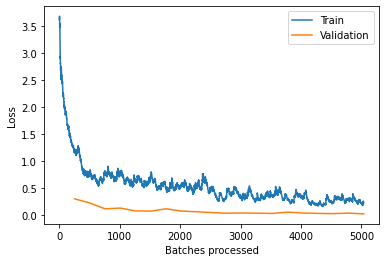

In [ ]:
learn2.recorder.plot_losses()

In [ ]:
preds = learn2.get_preds()[0].argmax(dim=-1).numpy()
test_actual = learn2.get_preds()[1].numpy()

In [ ]:
train_pred = learn2.get_preds(ds_type=DatasetType.Train)[0].argmax(dim=-1).numpy()
train_actual = learn2.get_preds(ds_type=DatasetType.Train)[1].numpy()

In [ ]:
val_acc = accuracy_score(test_actual, preds)
train_acc = accuracy_score(train_actual, train_pred)

In [ ]:
val_acc, train_acc

(0.9884259259259259, 0.19146825396825398)

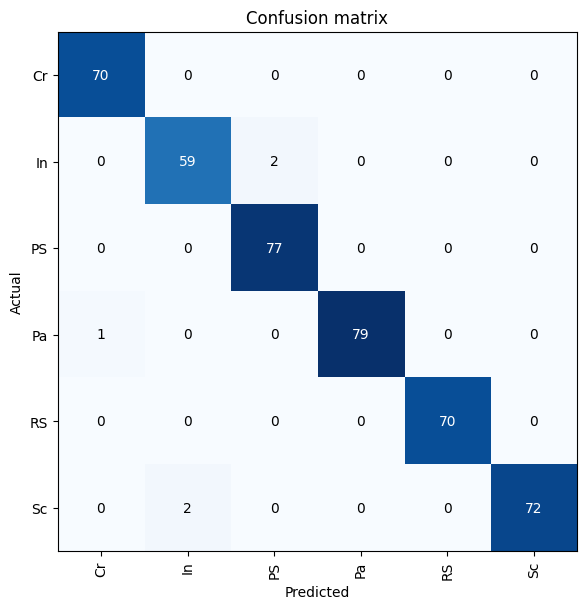

In [ ]:
interp = ClassificationInterpretation.from_learner(learn2)
interp.plot_confusion_matrix(figsize=(6,6), dpi=100)

In [ ]:
learn2.save('NEU-resnet34')

In [ ]:
learn2.export(image_path/'models/resnet34.pkl')

In [ ]:
learn2.load(image_path/'models/NEU-resnet34')

Learner(data=ImageDataBunch;

Train: LabelList (1009 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
Cr,Cr,Cr,Cr,Cr
Path: /content/drive/My Drive/IMAGES/train;

Valid: LabelList (432 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
Pa,Sc,PS,Pa,Sc
Path: /content/drive/My Drive/IMAGES/train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, af

In [ ]:
test_directory = r'/content/drive/My Drive/IMAGES/test'
images = []

for r, d, f in os.walk(test_directory):
    for file in f:
        #if file.endswith(".docx"):
        images.append(os.path.join(r, file))

In [ ]:
images

['/content/drive/My Drive/IMAGES/test/RS_13.bmp',
 '/content/drive/My Drive/IMAGES/test/RS_20.bmp',
 '/content/drive/My Drive/IMAGES/test/RS_27.bmp',
 '/content/drive/My Drive/IMAGES/test/RS_30.bmp',
 '/content/drive/My Drive/IMAGES/test/RS_31.bmp',
 '/content/drive/My Drive/IMAGES/test/RS_34.bmp',
 '/content/drive/My Drive/IMAGES/test/RS_43.bmp',
 '/content/drive/My Drive/IMAGES/test/RS_46.bmp',
 '/content/drive/My Drive/IMAGES/test/RS_48.bmp',
 '/content/drive/My Drive/IMAGES/test/RS_51.bmp',
 '/content/drive/My Drive/IMAGES/test/RS_55.bmp',
 '/content/drive/My Drive/IMAGES/test/RS_58.bmp',
 '/content/drive/My Drive/IMAGES/test/RS_59.bmp',
 '/content/drive/My Drive/IMAGES/test/RS_62.bmp',
 '/content/drive/My Drive/IMAGES/test/RS_71.bmp',
 '/content/drive/My Drive/IMAGES/test/RS_77.bmp',
 '/content/drive/My Drive/IMAGES/test/RS_82.bmp',
 '/content/drive/My Drive/IMAGES/test/RS_86.bmp',
 '/content/drive/My Drive/IMAGES/test/RS_93.bmp',
 '/content/drive/My Drive/IMAGES/test/RS_97.bmp',


In [ ]:
from fastai.vision import image
pred = []

for i in images:
    #img = image.open_image(test_directory+i)   # NameError: name 'image' is not defined  if image is not imported
    img = image.open_image(i)
    pred_class,pred_idx,outputs = learn2.predict(img)
    pred.append(str(pred_class))

In [ ]:
actual = []

for item in images:   # can be used if images are in sub-folders within test
#for item in os.listdir(test_directory):  # only when images are directly in "test"
    if 'Cr' in item:
        actual.append('Cr')
    if 'In' in item:
        actual.append('In')
    if 'Pa' in item:
        actual.append('Pa')
    if 'PS' in item:
        actual.append('PS')  
    if 'RS' in item:
        actual.append('RS')
    if 'Sc' in item:
        actual.append('Sc')    

In [ ]:
pred

['RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',

In [ ]:
actual

['RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',

In [ ]:
Test_Results={}

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

class_names = ['Cr', 'In', 'Pa', 'PS', 'RS', 'Sc']
report=classification_report(actual, pred, target_names=class_names)
Classifiaction_Report=classification_report(actual, pred, target_names=class_names)
Test_Results["Classification Report"]=Classifiaction_Report

In [ ]:
print(Classifiaction_Report)

              precision    recall  f1-score   support

          Cr       1.00      1.00      1.00        63
          In       0.98      1.00      0.99        60
          Pa       1.00      1.00      1.00        64
          PS       1.00      1.00      1.00        64
          RS       1.00      1.00      1.00        49
          Sc       1.00      0.98      0.99        59

    accuracy                           1.00       359
   macro avg       1.00      1.00      1.00       359
weighted avg       1.00      1.00      1.00       359



In [ ]:
def report_to_df(report):
    report = [x.split(' ') for x in report.split('\n')]
    header = ['Class Name']+[x for x in report[0] if x!='']
    values = []
    for row in report[1:-5]:
        row = [value for value in row if value!='']
        if row!=[]:
            values.append(row)
    df = pd.DataFrame(data = values, columns = header)
    return df

In [ ]:
Accuracy_Score=accuracy_score(actual, pred)
Test_Results["Accuracy_Score"]=Accuracy_Score
Accuracy_Score

0.9972144846796658

In [ ]:
import pandas as pd
Confusion_Matrix_List=[]
Confusion_matrix=pd.DataFrame(confusion_matrix(actual,pred,labels=class_names))
for index, row in Confusion_matrix.iterrows():
    Confusion_Matrix_List.append(list(row))
Test_Results["Confusion_Matrix"]=Confusion_Matrix_List

In [ ]:
print(Test_Results)

{'Classification Report': '              precision    recall  f1-score   support\n\n          Cr       1.00      1.00      1.00        63\n          In       0.98      1.00      0.99        60\n          Pa       1.00      1.00      1.00        64\n          PS       1.00      1.00      1.00        64\n          RS       1.00      1.00      1.00        49\n          Sc       1.00      0.98      0.99        59\n\n    accuracy                           1.00       359\n   macro avg       1.00      1.00      1.00       359\nweighted avg       1.00      1.00      1.00       359\n', 'Accuracy_Score': 0.9972144846796658, 'Confusion_Matrix': [[63, 0, 0, 0, 0, 0], [0, 60, 0, 0, 0, 0], [0, 0, 64, 0, 0, 0], [0, 0, 0, 64, 0, 0], [0, 0, 0, 0, 49, 0], [0, 1, 0, 0, 0, 58]]}


<Figure size 432x288 with 0 Axes>

Confusion matrix, without normalization
[[63  0  0  0  0  0]
 [ 0 60  0  0  0  0]
 [ 0  0 64  0  0  0]
 [ 0  0  0 64  0  0]
 [ 0  0  0  0 49  0]
 [ 0  1  0  0  0 58]]


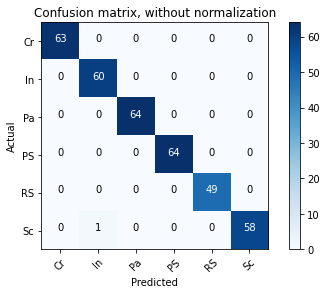

In [ ]:
cnf_matrix = confusion_matrix(actual, pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

In [ ]:
%timeit pred_class,pred_idx,outputs = learn2.predict(img)

10 loops, best of 3: 32 ms per loop


##Resnet18

In [ ]:
arch = models.resnet18
learn3 = cnn_learner(data, arch, pretrained=True, metrics=metrics)
learn3.loss_func = torch.nn.functional.cross_entropy

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
learn3.fit_one_cycle(20)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,1.173583,0.274858,0.881944,0.883135,0.881250,00:45
1,0.902056,0.230734,0.916667,0.928210,0.917538,00:46
2,0.783863,0.332023,0.905093,0.914939,0.904554,00:46
3,0.689094,0.232383,0.902778,0.911647,0.907755,00:45
4,0.786833,0.123332,0.960648,0.960537,0.962515,00:46
5,0.685621,0.081920,0.972222,0.971006,0.972520,00:46
6,0.647136,0.136076,0.958333,0.958985,0.959215,00:45
7,0.526107,0.093446,0.967593,0.967366,0.967480,00:46
8,0.629360,0.129295,0.965278,0.965046,0.967236,00:46
9,0.407942,0.104727,0.979167,0.977934,0.978330,00:46


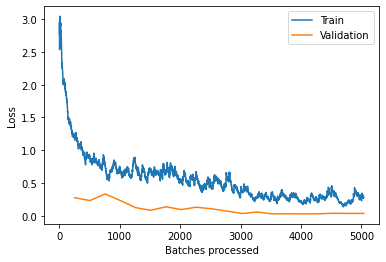

In [ ]:
learn3.recorder.plot_losses()

In [ ]:
preds = learn3.get_preds()[0].argmax(dim=-1).numpy()
test_actual = learn3.get_preds()[1].numpy()

train_pred = learn3.get_preds(ds_type=DatasetType.Train)[0].argmax(dim=-1).numpy()
train_actual = learn3.get_preds(ds_type=DatasetType.Train)[1].numpy()

val_acc = accuracy_score(test_actual, preds)
train_acc = accuracy_score(train_actual, train_pred)

val_acc, train_acc

(0.9930555555555556, 0.17063492063492064)

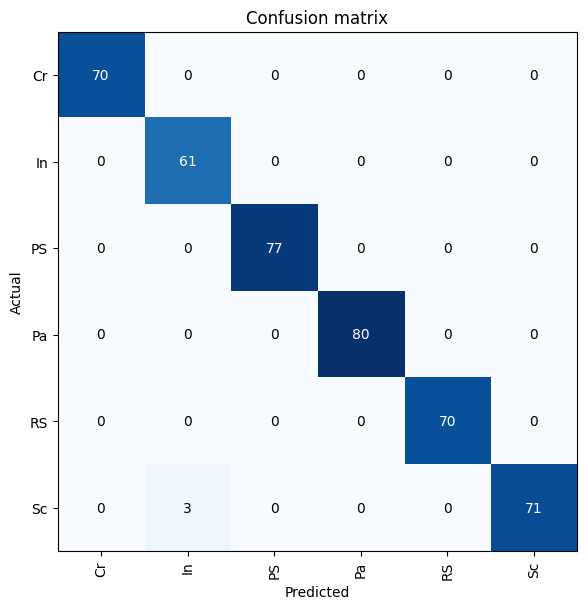

In [ ]:
interp = ClassificationInterpretation.from_learner(learn3)
interp.plot_confusion_matrix(figsize=(6,6), dpi=100)

In [ ]:
learn3.save('NEU-resnet18')

In [ ]:
learn3.export(image_path/'models/resnet18.pkl')

In [ ]:
learn3.load(image_path/'models/NEU-resnet18')

Learner(data=ImageDataBunch;

Train: LabelList (1009 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
Cr,Cr,Cr,Cr,Cr
Path: /content/drive/My Drive/IMAGES/train;

Valid: LabelList (432 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
Pa,Sc,PS,Pa,Sc
Path: /content/drive/My Drive/IMAGES/train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, af

In [ ]:
from fastai.vision import image
pred_18 = []

for i in images:
    #img = image.open_image(test_directory+i)   # NameError: name 'image' is not defined  if image is not imported
    img = image.open_image(i)
    pred_class,pred_idx,outputs = learn3.predict(img)
    pred_18.append(str(pred_class))

In [ ]:
actual_18 = []

for item in images:   # can be used if images are in sub-folders within test
#for item in os.listdir(test_directory):  # only when images are directly in "test"
    if 'Cr' in item:
        actual_18.append('Cr')
    if 'In' in item:
        actual_18.append('In')
    if 'Pa' in item:
        actual_18.append('Pa')
    if 'PS' in item:
        actual_18.append('PS')  
    if 'RS' in item:
        actual_18.append('RS')
    if 'Sc' in item:
        actual_18.append('Sc')   

In [ ]:
pred_18

['RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',

In [ ]:
actual_18

['RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'RS',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Pa',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',
 'Cr',

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

Test_Results = {}
class_names = ['Cr', 'In', 'Pa', 'PS', 'RS', 'Sc']
report=classification_report(actual_18, pred_18, target_names=class_names)
Classifiaction_Report=classification_report(actual_18, pred_18, target_names=class_names)
Test_Results["Classification Report"]=Classifiaction_Report

In [ ]:
print(Classifiaction_Report)

              precision    recall  f1-score   support

          Cr       1.00      1.00      1.00        63
          In       0.95      0.98      0.97        60
          Pa       1.00      0.98      0.99        64
          PS       1.00      1.00      1.00        64
          RS       1.00      1.00      1.00        49
          Sc       0.98      0.97      0.97        59

    accuracy                           0.99       359
   macro avg       0.99      0.99      0.99       359
weighted avg       0.99      0.99      0.99       359



In [ ]:
Accuracy_Score=accuracy_score(actual_18, pred_18)
Accuracy_Score

0.9888579387186629

In [ ]:
%timeit pred_class,pred_idx,outputs = learn3.predict(img)

10 loops, best of 3: 28.3 ms per loop


##Efficientnet


In [ ]:
! pip install --upgrade efficientnet-pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp36-none-any.whl size=16031 sha256=a9bb13f848e53f9f531bef073d3d2a3adfdb3e258b4f5e381c5aaba9e88f4099
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


In [ ]:
from efficientnet_pytorch import EfficientNet

arch = EfficientNet.from_name('efficientnet-b0')
learn4 = Learner(data, arch, metrics=metrics)
learn4.loss_func = torch.nn.functional.cross_entropy

In [ ]:
learn4.fit_one_cycle(20)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,1.505406,3.334616,0.141204,nan,nan,00:55
1,1.227077,5.462240,0.331019,nan,nan,00:54
2,1.246547,124.861458,0.208333,nan,nan,00:54
3,1.243350,112.918953,0.273148,nan,nan,00:54
4,1.279597,7.112821,0.361111,nan,nan,00:54
5,1.066635,0.722921,0.708333,nan,nan,00:54
6,0.985617,0.562172,0.766204,nan,nan,00:54
7,0.883532,0.544900,0.819444,nan,nan,00:54
8,0.703301,0.350920,0.881944,nan,nan,00:55
9,0.610576,0.226058,0.918981,nan,nan,00:54


##Mobilenet Training


In [ ]:
pkl_path = Path(r"/content/drive/My Drive/IMAGES/train/models")
learn_v2 = load_learner(pkl_path,'mobilenetv2.pkl')

In [ ]:
learn_v2

Learner(data=ImageDataBunch;

Train: LabelList (0 items)
x: ImageList

y: CategoryList

Path: /content/drive/My Drive/IMAGES/train/models;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: /content/drive/My Drive/IMAGES/train/models;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): Batch

In [ ]:
test_directory = r'/content/drive/My Drive/IMAGES/test'
images = []

for r, d, f in os.walk(test_directory):
    for file in f:
        #if file.endswith(".docx"):
        images.append(os.path.join(r, file))


In [ ]:
from fastai.vision import image
#pred_18 = []

for i in images:
    #img = image.open_image(test_directory+i)   # NameError: name 'image' is not defined  if image is not imported
    img = image.open_image(i)
    #pred_class,pred_idx,outputs = learn3.predict(img)
    #pred_18.append(str(pred_class))

In [ ]:
%timeit pred_class,pred_idx,outputs = learn_v2.predict(img)

The slowest run took 9.13 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 29.5 ms per loop
